#### 《我是大侦探》到底怎么了？（下：情感分析篇）

接上篇《我是大侦探》到底怎么了（上：数据爬取篇），这篇文章主要对爬取回来的数据进行情感分析，看看广大观众朋友们到底对于明侦的姊妹篇《我是大侦探》是怎么看的，以及对于这个节目里的每个嘉宾的表现是否满意，四期以来评论是否有好转的趋势等。

- 本文的数据处理和分析基于pandas，数据可视化基于matplotlib和seaborn
- 情感倾向分析基于snow_nlp、百度AI以及腾讯文智，分词基于jieba
- Python运行环境为3.6

(注：1-3章为数据获取和处理相关内容，可以直接跳到第4章看分析)

### 1. 从MongoDB中提取数据
上篇文章中使用scrapy爬取的数据是储存在MongoDB数据库中的，所以首先需要把数据从数据库中提取出来，转换为pandas DataFrame。提取数据需要用到pymongo包来操作MongoDB数据库：

- 首先实例化一个MongoClient，host为'127.0.0.1'，默认端口是27017，数据库为mongotv
- 我把四期的评论数据分别保存在mongotv数据库下的四个集合里面，分别是mongotv1，mongotv2，mongotv3，mongotv4，需要分别提取到data1, data2, data3, data4这四个pandas DataFrame里面
- 使用.find()方法可以查询到集合里面的每一条数据，通过遍历便可以得到这些数据
- 由于MongoDB中的数据是非结构化的JSON数据，可以使用pandas.io.json中的json_normalize方法，把JSON数据扁平化、规整化成为pandas的DataFrame，这里由于只需要评论数据，所以只提取了“comments”下面的数据

In [2]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from pandas.io.json import json_normalize

conn = MongoClient(host='127.0.0.1', port=27017)  # 实例化MongoClient
db = conn.get_database('mongotv3')  # 连接到mongotv数据库

mongotv1 = db.get_collection('mongotv1') # 连接到集合mongotv1
mon_data = mongotv1.find()  # 查询这个集合下的所有记录

# 遍历mon_data，获取每一条记录下的’comments‘数据，组装成一个列表
# 使用json_normalize把JSON数据扁平化成一个DataFrame，就成功地把第1期节目的评论数据成功地从MongoDB中提取出来并转换为pandas的DataFrame格式了
data1 = json_normalize([j['comments'] for j in mon_data], sep='_')

# 下面接着使用同样的方法提取第2、3、4期节目评论数据
data2 = json_normalize([j['comments'] for j in db.get_collection('mongotv2').find()], sep='_')
data3 = json_normalize([j['comments'] for j in db.get_collection('mongotv3').find()], sep='_')
data4 = json_normalize([j['comments'] for j in db.get_collection('mongotv4').find()], sep='_')

这样，便成功地把数据从MongoDB中拎出来啦。  
另外，我已把提取出来的数据持久化为csv文件，上传到Github了，传送门为：https://github.com/Alfred1984/interesting-python
  
### 2. 基本的数据处理
我们需要把四期的数据放在一个DataFrame里做分析，所以首先给每期的数据标记上期数（episode），再把四期评论数据一起concat起来，然后把这次分析上用不到的字段去除掉。

#### 2.1 每期评论数据处理
可见，第1、2、3、4期节目分别有9779、4246、3030、2089条评论

In [27]:
print(data1.shape, data2.shape, data3.shape, data4.shape)

(9779, 16) (4246, 16) (3030, 16) (2089, 16)


为每期数据增添新的一列“episode”，用来标记期数，再把四期的数据concat起来保存到data中

In [29]:
data1['episode'] = 1
data2['episode'] = 2
data3['episode'] = 3
data4['episode'] = 4

data = pd.concat([data1, data2, data3, data4])

#### 2.2 数据基本信息
- 发现数据总共有19144条，17列
- “comment_id”字段起到唯一标识每条评论的作用，由于爬取的时候已经基于该字段做了去重，所以并不需要再去重
- “content”就是评论的主要内容，也是我们主要分析的内容
- 所有以“origin_comment”开头的都是有回复的评论相关信息，例子如下，“有明显bug，邓有味不是亲生的怎么和他爷爷长的一样？？邓有味那套衣服他爷爷又是怎么得到的？？”就是“origin_comment_content”：

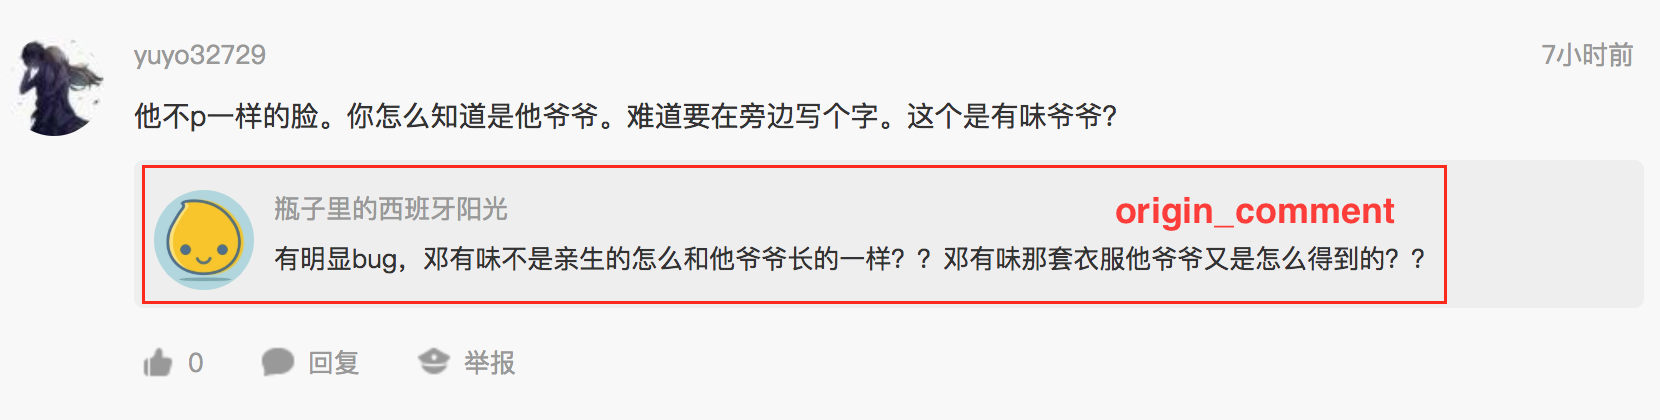
- “videoId”是每个视频的ID，其实这个也可以用来标示哪一期，不过我们刚刚有了更明显更加具有代表性的“episode”字段，所以这个字段可以不要了
- “user_nickname”是评论者的名字，“up_num”是评论获得的点赞数

In [30]:
data.shape

(19144, 17)

In [15]:
data.sample(3)

,comment_id,content,create_time,device,origin_comment_avatar_key,origin_comment_comment_id,origin_comment_content,origin_comment_create_time,origin_comment_device,origin_comment_up_num,origin_comment_user,origin_comment_videoId,up_num,user_avatar_key,user_nickname,videoId,episode
1837,1.04935e+08,这是明侦姊妹篇，明侦今天下半年会出来,19天前,phone,https://avatar.hitv.com/5/324a3423/WOUsQ5zZyWK...,0.0,双北cp了？撒撒了？白白了？\n无聊死了尬死了\n还是明星大侦探好\n粉了三季，看来要粉传黑了😂,NaN,pc,3.0,xujiayi嘉忆,4.32754e+06,0,https://eximg.hitv.com/2/mava2_tnuTpYihxI0cUln...,mg187542,4327535.0,1
6610,1.04897e+08,卫视版，满满的正能量😂😂,23天前,phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,https://avatar.hitv.com/6/9eb69851/WOUB9pzZyWK...,晔晨苡韵,4327535.0,1
5031,1.04903e+08,看完了，再次打开明星大侦探。,23天前,phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,https://avatar.hitv.com/6/df162aab/WOUOkJzZyWK...,QQ_9XAcl21Q7qAy,4327535.0,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19168 entries, 0 to 2090
Data columns (total 17 columns):
comment_id                    19167 non-null object
content                       19167 non-null object
create_time                   19166 non-null object
device                        19165 non-null object
origin_comment_avatar_key     4697 non-null object
origin_comment_comment_id     4696 non-null float64
origin_comment_content        4697 non-null object
origin_comment_create_time    1 non-null float64
origin_comment_device         4697 non-null object
origin_comment_up_num         4697 non-null float64
origin_comment_user           4697 non-null object
origin_comment_videoId        4698 non-null object
up_num                        19166 non-null object
user_avatar_key               19166 non-null object
user_nickname                 19165 non-null object
videoId                       19164 non-null float64
episode                       19168 non-null int64
dtypes: float64(

#### 2.3 字段选取
- 这里只选取comment_id，content，origin_comment_content，origin_comment_up_num，origin_comment_user，up_num，user_nickname，episode这8个字段进行后续分析

In [31]:
data = data[['comment_id', 'content', 'origin_comment_content', 'origin_comment_up_num', 
             'origin_comment_user', 'up_num', 'user_nickname', 'episode']]

In [72]:
data.sample(5)

,comment_id,content,origin_comment_content,origin_comment_up_num,origin_comment_user,up_num,user_nickname,episode
1759,1.04938e+08,真的不好看,NaN,NaN,NaN,1,ta58645,1
3849,104976006,期待名侦的同时看看我侦也是挺带劲儿的但没有你平常很不习惯哦,NaN,NaN,NaN,1,寂落无言,2
2838,105071494,有了大老师就有笑点了,NaN,NaN,NaN,15,Angel筱蝶,3
2462,104986153,😣😣😣,NaN,NaN,NaN,1,Miccy14大白痴,2
4031,1.04908e+08,不要用已经录了这么多期的明星大侦探和我是大侦探作比较好吗？毕竟新节目都需要磨合的，有得看就很...,NaN,NaN,NaN,2,空城悲凉i,1


### 3. 情感倾向获取
情感倾向也就是对包含主观观点信息的文本进行情感极性类别（积极、消极、中性）的判断，例如：
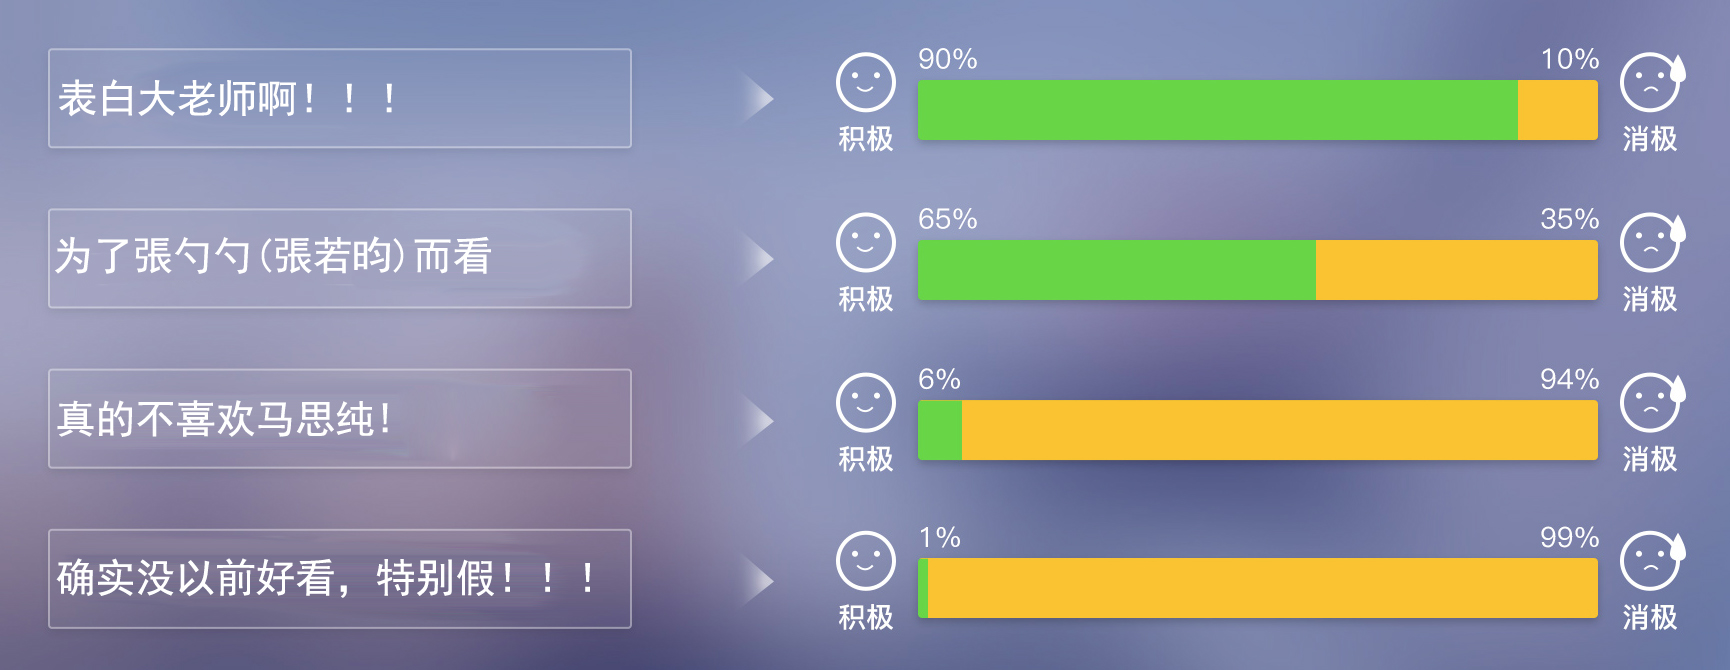
  
我们需要对爬取下来的每一条评论进行情感倾向分析，获取情感倾向值。该值可以以0-1之间的数字表示，越接近0代表评论越消极，越接近1代表评论越积极，越接近0.5代表评论越偏向于中性。这里，我们需要快速获取情感倾向值，便不涉及到数据打标和建模的过程，目前可以使用的工具有：
1. Python的中文文本分析库SnowNLP：它是一个python写的类库，可以方便的处理中文文本内容，是受到了TextBlob的启发而写的，目前实现了中文分词、词性标注、情感分析、文本关键词提取等功能，传送门：https://github.com/isnowfy/snownlp
2. 百度AI的情感倾向分析：它是百度AI开放平台的语言处理基础技术产品，提供了API接口以及SDK Python包，可以用来获取情感倾向，每天可以免费调用10万次，足够我们的分析了，传送门：http://ai.baidu.com/tech/nlp/sentiment_classify
3. 腾讯文智的情感分析API：它是腾讯文智自然语言处理的产品，同样提供了API和SDK调用来获取情感倾向，总共可以免费调用5万次，也足够我们的分析了。传送门：http://nlp.qq.com/index.cgi

3种工具的调用方法分别如下：
- SnowNLP：
很简单，只要实例化一个SnowNLP类，传入需要分析的文本，再调用sentiments方法便可获取情感倾向值，比如：

In [56]:
from snownlp import SnowNLP

s = SnowNLP('何老师大赞！')
s.sentiments

0.9867922309885194

- 百度AI：
先pip install baidu-aip安装SDK，然后注册账号，获取到APP_ID、API_KEY和SECRET_KEY，根据这个实例化一个AipNlp类，然后调用sentimentClassify方法传入文本，便可以返回情感倾向分析的相关内容，比如：

In [57]:
from aip import AipNlp

""" 你的 APPID AK SK """
APP_ID = '你的 App ID'
API_KEY = '你的 Api Key'
SECRET_KEY = '你的 Secret Key'

client = AipNlp(APP_ID, API_KEY, SECRET_KEY)
client.sentimentClassify('好喜欢大老师！')

{'items': [{'confidence': 0.877612,
   'negative_prob': 0.0550744,
   'positive_prob': 0.944926,
   'sentiment': 2}],
 'log_id': 3360158832388033297,
 'text': '好喜欢大老师！'}

返回一个字典，其中“positive_prob”便是我们需要的情感倾向值。不过有一点需要注意的是，它仅支持GBK编码的文本。评论中有很少部分的emoji并不能被encode成“GBK”编码，运行时会报错，这时可以先把这些emoji处理一下。而我就比较懒了，我直接去修改了一下AipNlp类的源码，里面有一个_proccessRequest方法，encode的时候加上“ignore”就可以了。
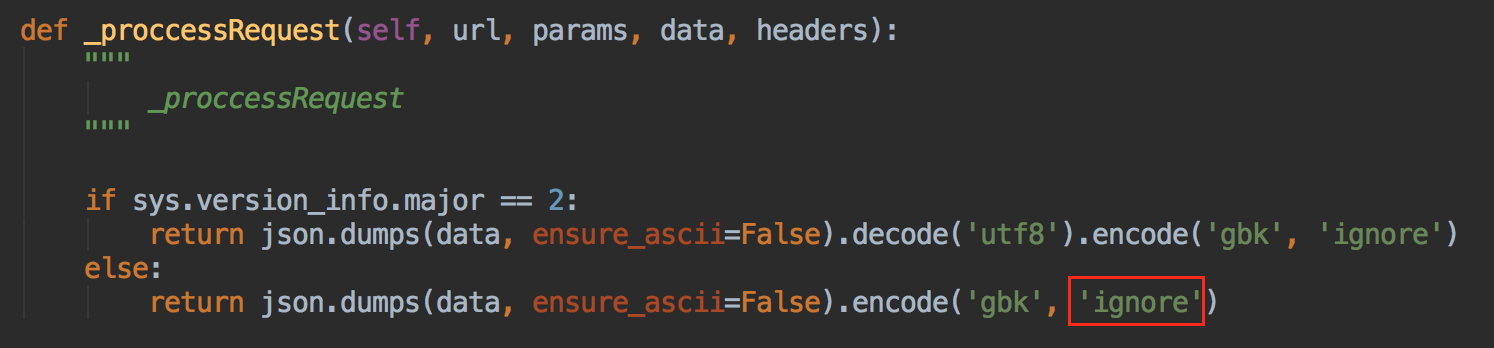

- 腾讯文智：
腾讯文智稍微有些麻烦，而且说明文档组织地不是很好。先pip install qcloudapi-sdk-python安装SDK，然后注册账号，获取secretId和secretKey，还有一串儿的参数配置，如下：

In [73]:
from QcloudApi.qcloudapi import QcloudApi
import requests

module = 'wenzhi'
action = 'TextSentiment'
config = {'Region':'gz',
          'secretId':'你的 secretId',
          'secretKey':'你的 secretKey'}
service = QcloudApi(module, config)
action_params = {'content': '真的不好看'}
url = service.generateUrl(action, action_params)
requests.get(url).json()

{'code': 0,
 'codeDesc': 'Success',
 'message': '',
 'negative': 0.87096798419952,
 'positive': 0.12903200089931}

同样，返回一个字典，其中“positive_prob”便是我们需要的情感倾向值。

  
由于评论数据在data['content']里，这里可以定义三个函数，用来分别获取SnowNLP、百度AI、腾讯文智的情感倾向值。然后使用data['content'].apply(func)便可以直接把数据获取到“sent_snownlp”、“sent_baidu”、“sent_tencent”字段里，具体如下：

In [ ]:
import pandas as pd
import requests
from snownlp import SnowNLP
from aip import AipNlp
from QcloudApi.qcloudapi import QcloudApi


# SnowNLP API


def get_sent_snownlp(data):
    s = SnowNLP(data)
    return s.sentiments


data['sent_snownlp'] = data['content'].apply(get_sent_snownlp)

# 百度API
APP_ID = '11128642'
API_KEY = 'odAzooF9AuFhKTFScWGnleTZ'
SECRET_KEY = 'mHWaMrh5EXPhb5tkdKode5uxVemhtf13'

client = AipNlp(APP_ID, API_KEY, SECRET_KEY)


def get_sent_baidu(data):
    return_data = client.sentimentClassify(data)
    items = return_data.get('items')  
    if items:
        return items[0]['positive_prob']


data['sent_baidu'] = data['content'].apply(get_sent_baidu)


# 腾讯API
module = 'wenzhi'
action = 'TextSentiment'
config = {'Region':'gz',
          'secretId':'AKID6JQM5c813zkNvNuomifcMxPIA2mLitrs',
          'secretKey':'GRQGzWs8D5kDUYR8e2KQK3f5TitsfKo6'}
service = QcloudApi(module, config)


def get_sent_tc(data):

    action_params = {'content': data}
    url = service.generateUrl(action, action_params)
    response = requests.get(url).json()
    positive = response.get('positive')
    if positive is not None:
        return positive


data['sent_tencent'] = data['content'].apply(get_sent_tc)

data.to_csv('/Users/apple/Desktop/data.csv', index=False)

获取完情感倾向值的数据长这样：

In [118]:
data.sample(3)

,comment_id,content,origin_comment_content,origin_comment_up_num,origin_comment_user,up_num,user_nickname,episode,sent_snownlp,sent_baidu,sent_tencent
492,105143925,怎么没有白敬亭,NaN,NaN,NaN,0,秋香99ehx,3,0.431900,0.251187,0.157837
3039,104981738,这个是我是大侦探。那个更新了三季的是明星大侦探。不是一个节目( ˘&bull;&omega;...,越办越低档了感觉,2.0,mg76987054kSU,0,请叫我牛哄哄,2,0.988480,0.549630,0.500000
1536,105085742,但她没时间策划,最迫切的不是马上演吗，他爱人今天就要死了啊,2.0,mg05024932LGM,0,安静的人3,3,0.476928,0.535489,0.500000


### 4. 具体分析
接下来便可以进行具体的分析了。  
随机抽取数据发现，snownlp在这个数据集上面的表现并不是很好（可能因为snownlp主要的训练数据是商品评论数据），所以本次分析主要综合一下百度AI和腾讯文智的分值。

In [126]:
data[['content', 'sent_snownlp', 'sent_baidu', 'sent_tencent']].sample(5)

,content,sent_snownlp,sent_baidu,sent_tencent
8347,好搞笑又,0.528718,0.612775,0.957584
8165,发的真差,0.067456,0.037499,0.155092
3489,不好看了没有前两季好看,0.957487,0.273358,0.581449
695,这个名字取的，让我。。。。。。,0.420059,0.648537,0.500000
3034,好像你们，,0.432961,0.484090,0.500000


In [19]:
data['sent_average'] = data[['sent_baidu', 'sent_tencent']].mean(axis=1)

对百度AI和腾讯文智的分值求平均，保存到“sent_average”中，后续的分析基于“sent_average”展开。

其实我的问题主要有以下几个：
1. 这部综艺评论的情感倾向总体如何？
2. 四期以来的情感倾向分布如何，趋势如何？
3. 评论区的观众们对于《我是大侦探》中的每个嘉宾评价如何，趋势如何？
4. 评论区对于《明星大侦探》的原班嘉宾鬼鬼、撒撒、白敬亭、王鸥等人的呼唤声有多大？

#### 4.1 这部综艺评论的情感倾向总体如何？
- 情感倾向值的平均分为0.52（0-1分值），查了一下豆瓣的评分，与豆瓣的5.6分（0-10分值）还是挺接近的，与《明星大侦探》的评分相比相差甚远啊（第一季：8.9，第二季：9.0，第三季：9.2）
- 由情感倾向值的分布图可以看到，这部综艺的评论可谓是毁誉参半。除了中间峰值的中性评论之外，如果我们以小于0.4为消极评论，大于0.6为积极评论来算的话，那么消极评论条数为5708条，积极评论为6384条，相差无几
- 看来很多老粉对于这部综艺是失望的，对于不同于《明星大侦探》的新嘉宾的表现不甚满意，怀念以前的老嘉宾，也有很多老粉一如既往地支持这个姊妹篇，希望以后越来越好，当然还有新嘉宾的铁粉过来摇旗呐喊

In [20]:
data['sent_average'].mean()

0.5249308097932136

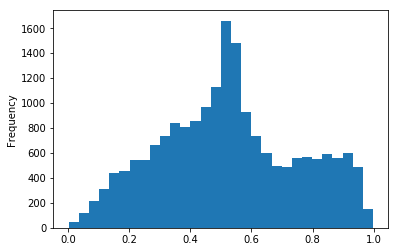

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data['sent_average'].plot.hist(bins = 30)

In [214]:
pd.cut(data['sent_average'], [0, 0.4, 0.6, 1]).value_counts()

(0.4, 0.6]    7042
(0.6, 1.0]    6384
(0.0, 0.4]    5708
Name: sent_average, dtype: int64

随机抽取消极和积极倾向的评论，可以看到大家失望和喜欢的点都在哪里

In [215]:
data.loc[data['sent_average'] < 0.2, ['content', 'sent_average']].sample(5)

,content,sent_average
1489,不好意思 那您滚回去看第一期叭 后面的可能都有他 气死你怎么得了~,0.155250
1948,恐怕要失望了,0.093704
7264,没有撒没有鬼没有白也没有欧只有何，一点也不好看，剧情很乱全程只有何的节奏还好张若昀还好因为上...,0.183291
989,广告太多了,0.186118
376,跟明星大侦探简直没法比，为什么原班人马打造的不按原来的模式玩,0.196553


In [217]:
data.loc[data['sent_average'] > 0.8, ['content', 'sent_average']].sample(5)

,content,sent_average
2434,比第一期好很多了，感觉到了节目组的进步与诚意,0.819971
468,大爱张天爱,0.809042
598,我是冲着韩雪来滴，喜欢她，希望她多出作品,0.832837
2400,比第一期好看,0.913630
6722,我觉得挺好的啊,0.896782


#### 4.2  四期以来的情感倾向分布如何，趋势如何？
- 可以看到，大家对于第01期的评价是最低的，平均值为0.5，可以算是严格意义上的毁誉参半，这也解释了为什么我当时看到第01期的时候心中有种说不出道不明的感觉
- 后续第02、03期，评价有所回升，看来大家对于这两期的内容认可度有上升，但是第04期又降下去了
- 由分布图可以明显看出，第01期、04期消极和积极两端都有比较明显的小峰值，而第02、03期积极一端有明显峰值

In [26]:
data.groupby('episode')['sent_average'].mean()

episode
1    0.503730
2    0.553011
3    0.552986
4    0.526419
Name: sent_average, dtype: float64

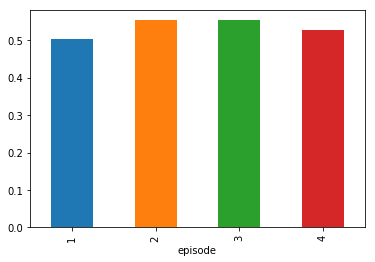

In [30]:
data.groupby('episode')['sent_average'].mean().plot.bar()

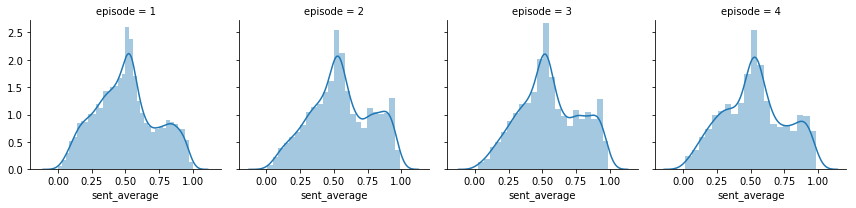

In [33]:
g = sns.FacetGrid(data, col="episode")
g = g.map(sns.distplot, "sent_average")

#### 4.3 评论区的观众们对于《我是大侦探》中的每个嘉宾评价如何，趋势如何？
我们由每一条评论里面提及到的嘉宾名字为统计依据，把涉及到各个嘉宾的评论进行标记并分别按列保存，这样可以方便我们计算关于各个嘉宾的评价平均值
- 由图可以看到，四期以来的评论区对于马思纯的评价是最低的，只有0.52，对于邓伦的评价是最高的，有0.68
- 最受欢迎的三位嘉宾是：邓伦、大张伟和吴磊小哥哥，最受diss的三位嘉宾是：马思纯、韩雪和张天爱

In [109]:
mapping = {'hejiong':'何|炅', 'wulei':'吴磊|磊', 'masichun':'马思纯|马上演', 'denglun':'邓|邓伦', 
           'zhangruoyun':'张若昀', 'hanxue':'韩|雪', 'zhangtianai':'张|天爱', 'dazhangwei':'大老师|大张伟'}
for key, value in mapping.items():
    data[key] = data['content'].str.contains(value)

In [110]:
average_value = pd.Series({key: data.loc[data[key], 'sent_average'].mean() for key in mapping.keys()})
print(average_value.sort_values())

masichun       0.516045
hanxue         0.544703
zhangtianai    0.546964
hejiong        0.554263
zhangruoyun    0.591087
wulei          0.613303
dazhangwei     0.632867
denglun        0.679709
dtype: float64


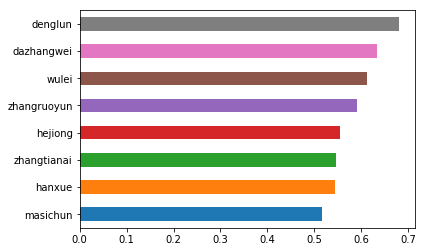

In [111]:
average_value.sort_values().plot.barh()

再以每集分组，看每位嘉宾的评价趋势如何，四期以来好评是否有回升？
- 由于某些嘉宾并没有四期都参加，所以把没有参加的对应数据设置为缺失值

In [112]:
average_by_episode = pd.DataFrame(
    [data.loc[data[key], ['episode', 'sent_average']].groupby('episode')['sent_average'].mean().rename(key) 
    for key in mapping.keys()])

In [113]:
average_by_episode.loc['hanxue', 2] = np.nan
average_by_episode.loc['zhangruoyun', [3,4]] = np.nan
average_by_episode.loc['masichun', 1] = np.nan
average_by_episode.loc['dazhangwei', 1] = np.nan
average_by_episode.loc['zhangtianai', [2,3,4]] = np.nan

In [114]:
average_by_episode

episode,1,2,3,4
hejiong,0.518645,0.601871,0.613305,0.564223
wulei,0.579723,0.643778,0.643693,0.633074
masichun,NaN,0.515675,0.541121,0.476268
denglun,0.687046,0.721919,0.668305,0.605552
zhangruoyun,0.610116,0.658719,NaN,NaN
hanxue,0.566495,NaN,0.496410,0.549538
zhangtianai,0.536439,NaN,NaN,NaN
dazhangwei,NaN,0.636987,0.656526,0.575733


- 可以发现，几乎每位嘉宾第一期的评价都是最低的，在第2、3期的时候普遍有回升，第四期的时候又有回落
- 第一期最低评价得分居然是何老师（通过抽取数据发现，大家只是对于何老师一个人撑起一个团队不满，对于最后何老师被误投生气）
- 马思纯拿到了第二期和第四期的最低分，韩雪拿了第三期的最低分，而且她们都有平均值低于0.5的评价
- 评论区关于马思纯的吐槽点大部分是不喜欢、尴尬、很假，关于韩雪的吐槽点是尬演、有点作、没有综艺感，看来作为金马奖影后的马思纯，可能在参加该类综艺的时候也是需要再调整调整姿态才行；作为在《声临其境》中惊爆全场的韩雪，带着老艺术家的专业和演技，没想到在这个比较偏向年轻人的节目中却由于演过了遭遇了一次滑铁卢。

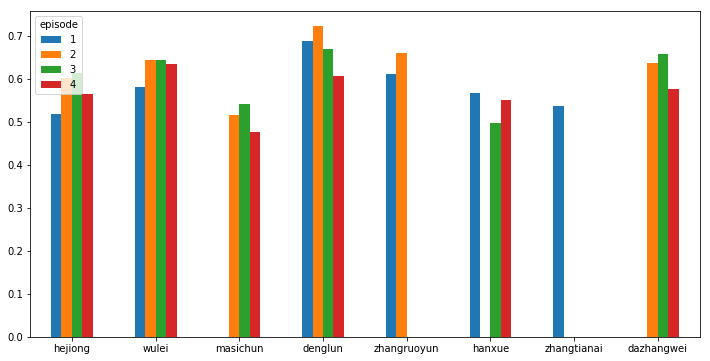

In [115]:
average_by_episode.plot.bar(figsize=(12, 6), rot=0)

In [120]:
average_by_episode.idxmin(axis=0)

episode
1     hejiong
2    masichun
3      hanxue
4    masichun
dtype: object

In [122]:
average_by_episode.min(axis=1)

hejiong        0.518645
wulei          0.579723
masichun       0.476268
denglun        0.605552
zhangruoyun    0.610116
hanxue         0.496410
zhangtianai    0.536439
dazhangwei     0.575733
dtype: float64

In [126]:
data.loc[data['hejiong']&data['episode'] == 1, 'content'].sample(5)

15274                               何老师越来越有小情绪啦，表情标一波一波的😄😂
5631                 这期也太差了吧，明明线索这么明显，还投何老师，肯定是磊或者爱啊，心疼何老师
5032                      真的没有明星大侦探好！太没意思，特别尴尬，只有何老师在cue流程
16145                                  邓伦帅帅哒，韩雪美美哒，何老师棒棒哒😘
1674     真想用大潘的话说一句，好尴尬呀～张扔出一个梗没有人接，只有何老师笑了，看了半个小时只能说只有...
Name: content, dtype: object

In [130]:
data.loc[data['masichun'], 'content'].sample(5)

13763             能不能不要有马思纯，不喜欢
16251              马思纯在快本就表演了吞拳
17537                    马思纯太做作
15532    马思纯真的是尬笑啊，隔着屏幕我都能感受到尴尬
10883           这集有马思纯在，我就不觉得假了
Name: content, dtype: object

In [128]:
data.loc[data['hanxue'], 'content'].sample(5)

16351        请韩雪注意下这是推理综艺不是演技类节目 一点综艺感都没有就不要上综艺节目好吗 希望请小白 
6703                                               感觉韩雪好漂亮
17678    有意见是希望你发表在人家演绎作品方面，而不是独看个面缘就说不喜欢，可以不喜欢，不要这样子，其...
15661                                           觉得韩雪真的有点做作
7622                                               韩雪好假好烦她
Name: content, dtype: object

看看邓伦、韩雪、马思纯的评论情感倾向分布如何：
- 可以看到，邓伦在第1、2、3期里面具有压倒性的积极评价

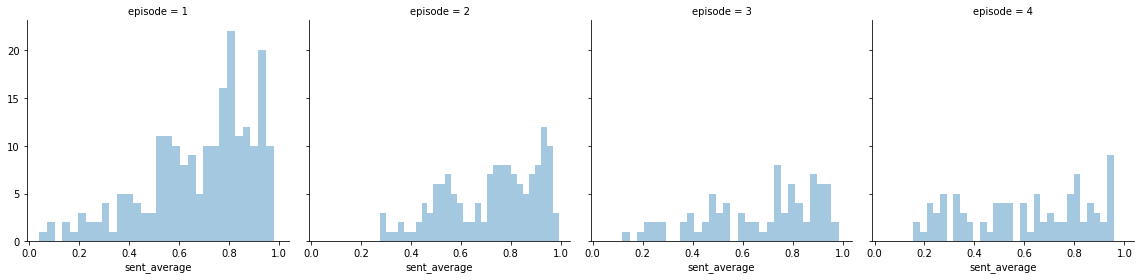

In [166]:
denglun = data.loc[data['denglun'], ['episode', 'sent_average']]
g = sns.FacetGrid(denglun, col="episode", size=4)
g = g.map(sns.distplot, "sent_average", bins=30, kde=False)

- 韩雪参与的第1期和第4期，评价的两极性都很明显，说明有一部分人非常不满意她的表现，还有一部分忠实粉丝非常支持她的表现
- 在第3期中，有更多的人是不满意韩雪的表现的

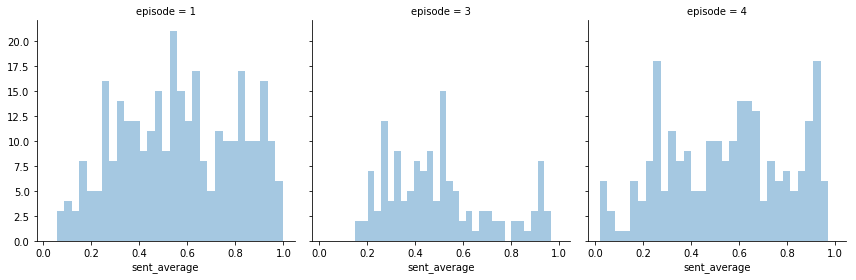

In [163]:
hanxue = data.loc[data['hanxue']&data['episode'].isin([1,3,4]), ['episode', 'sent_average']]
g = sns.FacetGrid(hanxue, col="episode", size=4)
g = g.map(sns.distplot, "sent_average", bins=30, kde=False)

- 可以看到，马思纯参与的3期节目中，评价的两极性都很明显，而且偏向于消极的趋势更加明显

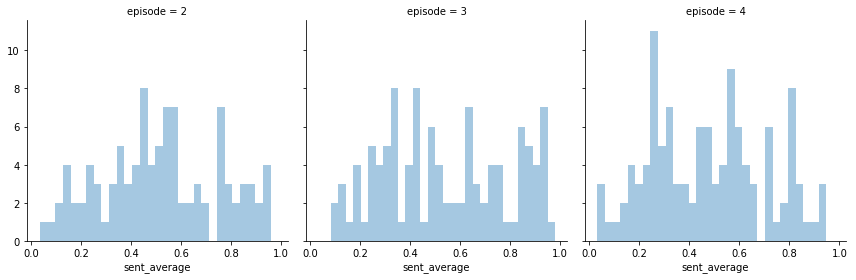

In [167]:
masichun = data.loc[data['masichun']&data['episode'].isin([2,3,4]), ['episode', 'sent_average']]
g = sns.FacetGrid(masichun, col="episode", size=4)
g = g.map(sns.distplot, "sent_average", bins=30, kde=False)

#### 4.4 评论区对于《明星大侦探》的原班嘉宾鬼鬼、撒撒、白敬亭、王鸥等人的呼唤声有多大？
可以看到评论区时不时就在抱怨为什么不是原班人马来录制的，还有很多对于原班人马鬼鬼、撒撒、白敬亭、王鸥等人的呼唤。那么到底这个呼唤声多大才能让导演听见呢？评论区又是对于原班人马谁的呼唤声最大呢？
- 可以看到, 有超过20%的评论都在呼唤原班人马鬼鬼、撒撒、白敬亭、王鸥等人，也就是说，5条评论中就有1条评论是在呼唤原班人马的
- 而评论区中对于小白白敬亭的呼声是最大的，达到了2400多条，其次是芳心纵火犯撒撒撒贝宁，也接近两千条，希望可以在后面几期的节目中看到他们吧

In [180]:
mapping_pre = {'guigui':'鬼', 'sabeining':'撒|芳心纵火犯', 'baijingting':'白', 'wangou':'王|鸥'}
for key, value in mapping_pre.items():
    data[key] = data['content'].str.contains(value)

In [193]:
sum(data[['guigui', 'sabeining', 'baijingting', 'wangou']].sum(axis=1) > 0)/data.shape[0]

0.2015252820727121

In [185]:
data[['guigui', 'sabeining', 'baijingting', 'wangou']].sum()

guigui         1119
sabeining      1967
baijingting    2421
wangou          256
dtype: int64

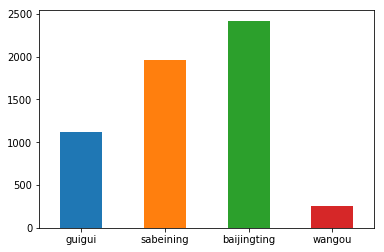

In [184]:
data[['guigui', 'sabeining', 'baijingting', 'wangou']].sum().plot.bar(rot=0)

### 5. 词云图
由于篇幅太长，这次的分析没有涉及到词频统计、词性分析等内容。老师说，一千个人的眼中有一千个哈姆雷特，每个人对于一部剧的理解都各不相同，那就来生成一张词云图吧，大家都可以从中看到自己想看的内容，喜欢该综艺的人可以看到“好看”、“喜欢”、“搞笑”、“不错”等字眼，不喜欢该综艺的人可以看到“不喜欢”、“尴尬”、“无聊”、“不好”等字眼。而我，我就是一个臭分析数据的，我只摆事实，不带节奏。

In [210]:
import jieba
from collections import Counter

data['content'] = data['content'].astype('str')
text = ''.join(data['content'])

jieba.add_word('明星大侦探')
jieba.add_word('我是大侦探')
jieba.add_word('何老师')
jieba.add_word('大老师')
jieba.add_word('雪笑笑')
jieba.add_word('撒撒')
jieba.add_word('撒老师')
jieba.add_word('没有明星大侦探好看')
jieba.add_word('不适合')
jieba.add_word('不喜欢')
jieba.add_word('飙演技')

words = list(jieba.cut(text))
swords = [x.strip() for x in open ('/Users/apple/Desktop/stopwords.txt')]

ex_sw_words = []
for word in words:
    if len(word)>1 and (word not in swords):
        ex_sw_words.append(word)

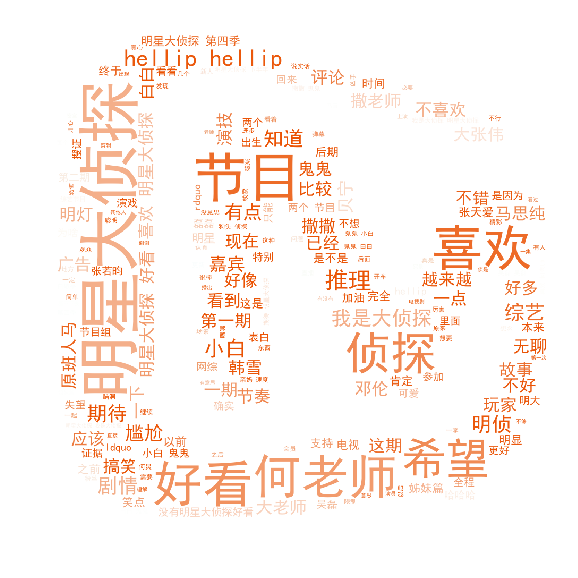

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import PIL.Image as Image

coloring = np.array(Image.open("/Users/apple/Desktop/mongo.jpeg"))
image_colors = ImageColorGenerator(coloring)
my_wordcloud = WordCloud(background_color="white", max_words=200,
                         mask=coloring, max_font_size=60, random_state=42, scale=2,
                         font_path="/Library/Fonts/Microsoft/SimHei.ttf").generate(' '.join(ex_sw_words))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(my_wordcloud.recolor(color_func=image_colors))

### 6. 总结
- 总的来说，这个数据还是挺好玩的
- 后续可以对该数据进行打标，然后尝试各种方法来自行建模分类预测，这便是自然语言处理的内容了
- 数据、代码和分析过程已上传到Github，传送门为：https://github.com/Alfred1984/interesting-python/ ，同时上传的还有我珍藏多年的、综合各方的停用词表
- 肚子饿了，我要去吃饭了